## Position Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from scipy.stats import boxcox, zscore

In [2]:
# Global parameters

# Current gameweek 
gameweek = 11

# Number of gameweeks to calculate rolling averages off 
rolling_number = 3

## Collect available player data

In [3]:
# Initialize an empty list to store all individual, player gameweek data 
all_player_sep = []

# Loop through each gameweek
for i in range(1, gameweek + 1):  # Adjusting the range to start from 1 to gameweek
    # Read the CSV for the current gameweek
    x = pd.read_csv(rf'C:\Users\thoma\Code\Projects\Fantasy-Premier-League\Data\Players\Seperate_GW\GW_{i}.csv')
    
    # Append the current gameweek data to the list
    all_player_sep.append(x)

# Concatenate all dataframes in the list into a single dataframe
player_data = pd.concat(all_player_sep, axis=0, ignore_index=True)

# Drop unnamed column
player_data = player_data.drop(columns = ['Unnamed: 0'])

In [4]:
# Remove players who play less than 61 minutes in a game (i.e. they do not recieve their 2 points minimum for playoing this amount)
player_data = player_data[player_data['Minutes'] > 60].copy()

In [5]:
# Filter by Goalkeepers, Defenders, Midfielders, and Forwards
final_data_mids = player_data[player_data['Position'] == 'MID'].copy()
final_data_defs = player_data[player_data['Position'] == 'DEF'].copy()
final_data_gks = player_data[player_data['Position'] == 'GK'].copy()
final_data_fwds = player_data[player_data['Position'] == 'FWD'].copy()

In [6]:
## Assess sample size of each category
print(f'GK:',final_data_gks.shape)
print(f'DEF:',final_data_defs.shape)
print(f'MID:',final_data_mids.shape)
print(f'FWD:',final_data_fwds.shape)

GK: (219, 33)
DEF: (859, 33)
MID: (952, 33)
FWD: (218, 33)


In [7]:
mean_week_points = []

# Iterate through each unique position and gameweek
positions = player_data['Position'].unique()
gameweeks = player_data['Gameweek'].unique()

for pos in positions:
    for gameweek in gameweeks:
        # Filter data for the specific position and gameweek
        data = player_data[(player_data['Position'] == pos) & (player_data['Gameweek'] == gameweek)]
        if not data.empty:
            mean = round(data['GW Points'].mean(), 2)
        else:
            mean = 0  # Default to 0 if no data is available
        mean_week_points.append((gameweek, mean, pos))

# Create a DataFrame from the calculated mean points
mean_week_points_df = pd.DataFrame(mean_week_points, columns=['Gameweek', 'Mean Points', 'Position'])

In [8]:
mean_week_points_df

,Gameweek,Mean Points,Position
0,1,2.83,DEF
1,2,2.80,DEF
2,3,2.04,DEF
3,4,3.17,DEF
4,5,2.70,DEF
5,6,2.33,DEF
6,7,3.16,DEF
7,8,2.77,DEF
8,9,2.32,DEF
9,10,2.91,DEF


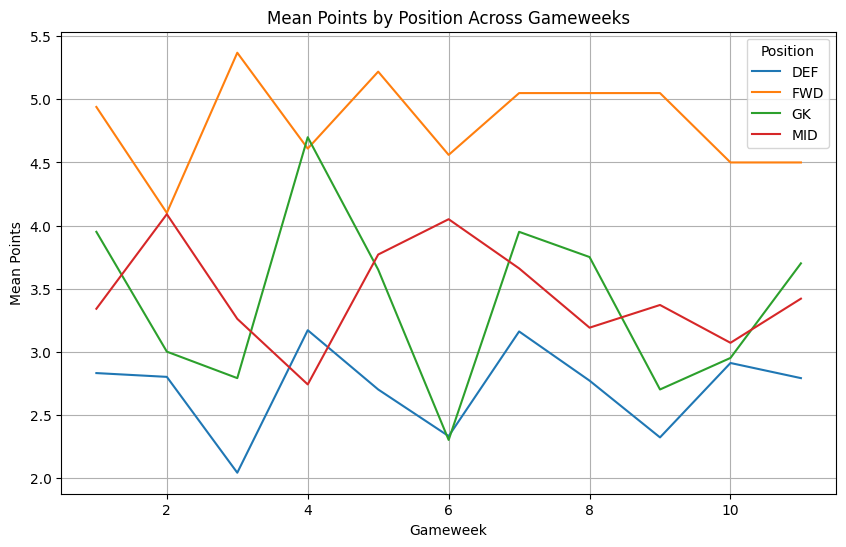

In [ ]:
# Visualize the results
plt.figure(figsize=(10, 6))
for pos, group_data in mean_week_points_df.groupby('Position'):
    plt.plot(group_data['Gameweek'], group_data['Mean Points'], label=pos)

# Add labels and title
plt.xlabel('Gameweek')
plt.ylabel('Mean Points')
plt.title('Mean Points by Position Across Gameweeks')
plt.legend(title='Position')
plt.grid(True)
plt.show()

In [ ]:
## Covariances, partial correlation analysis